Opening raw data file C:\Users\marin\mne_data\MNE-sample-data\MEG\sample\sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...


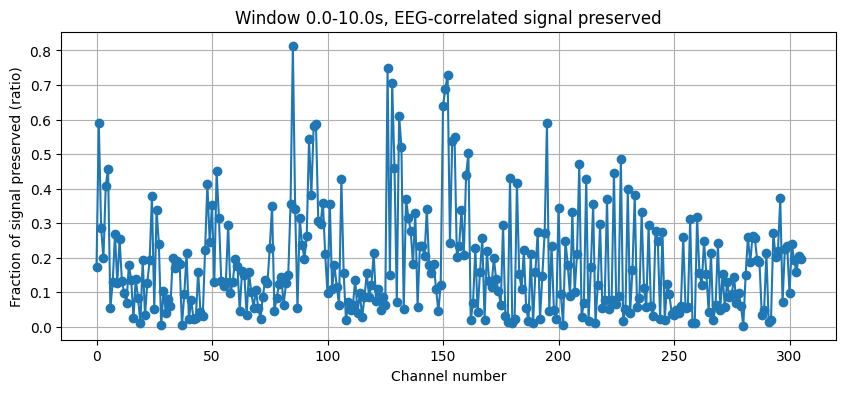

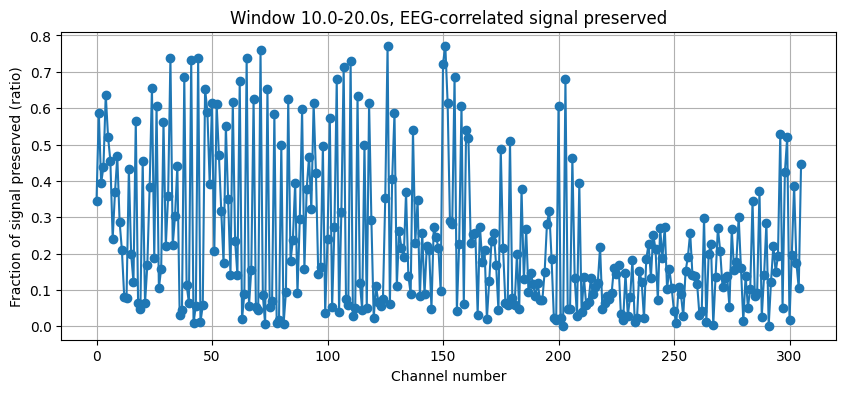

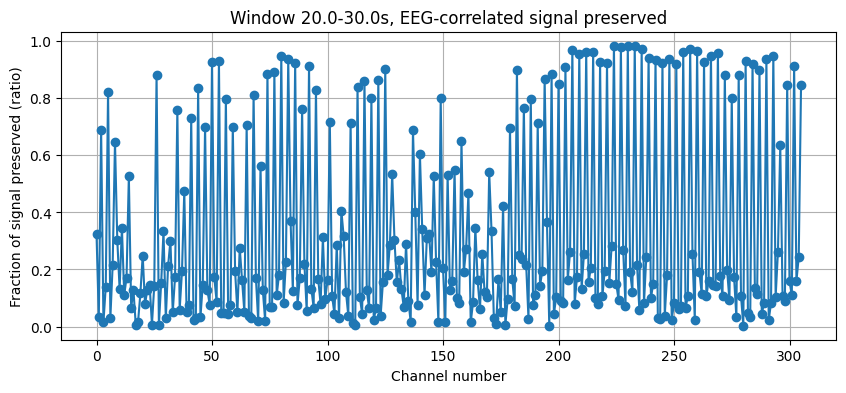

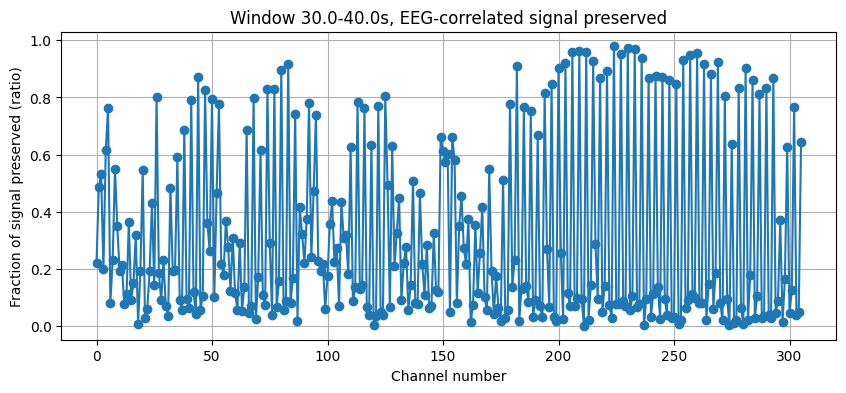

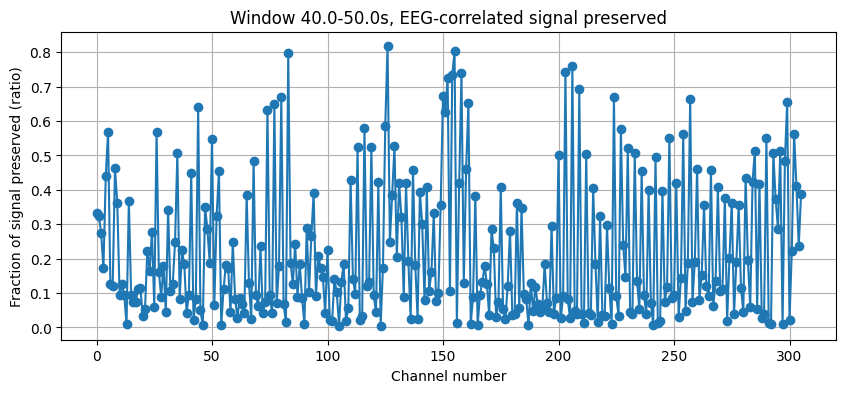

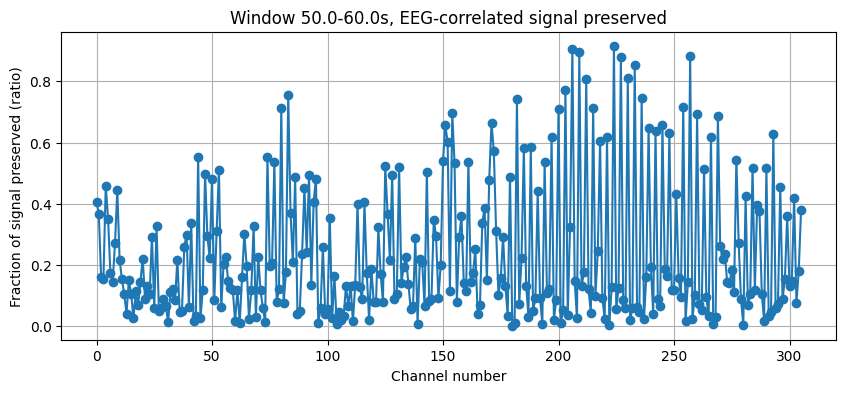

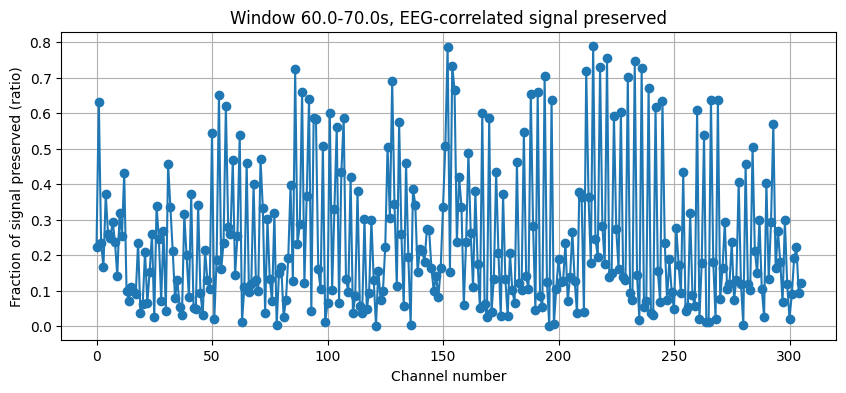

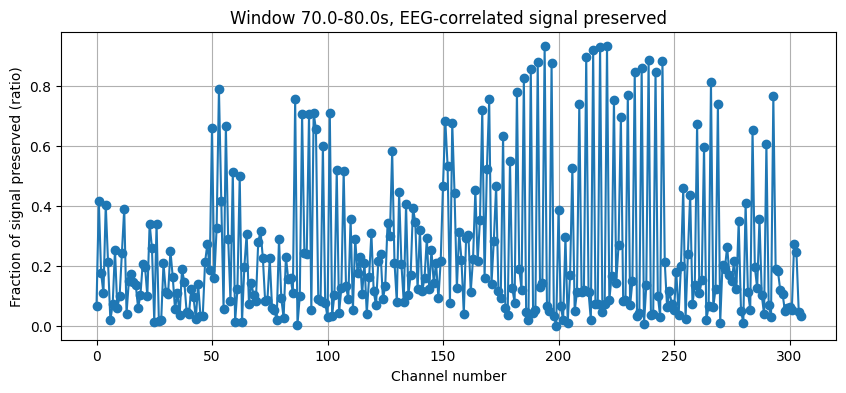

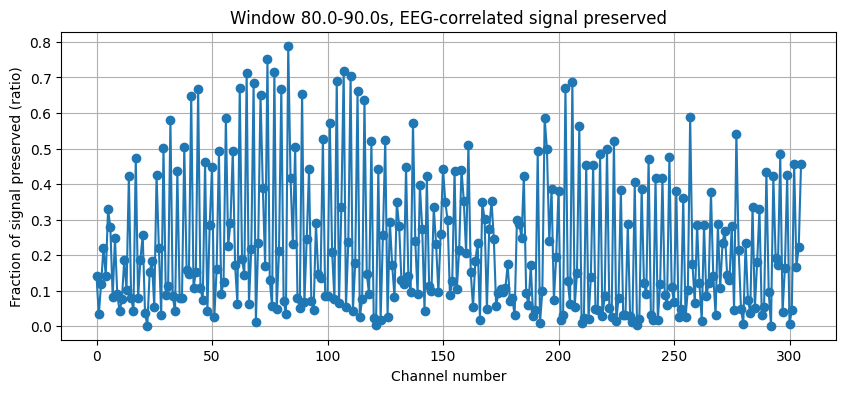

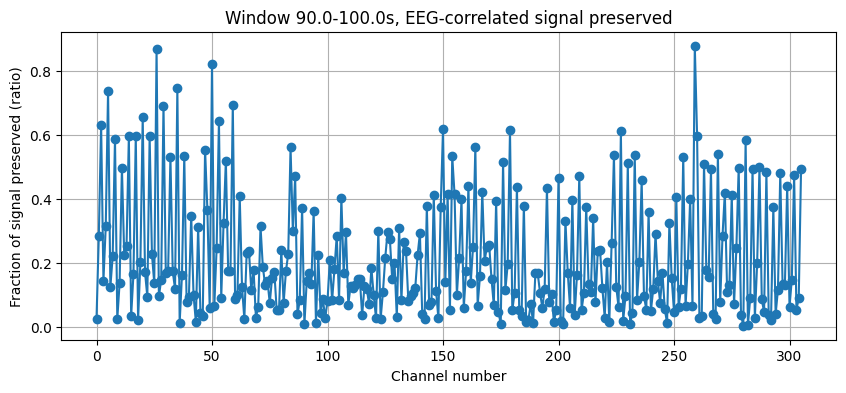

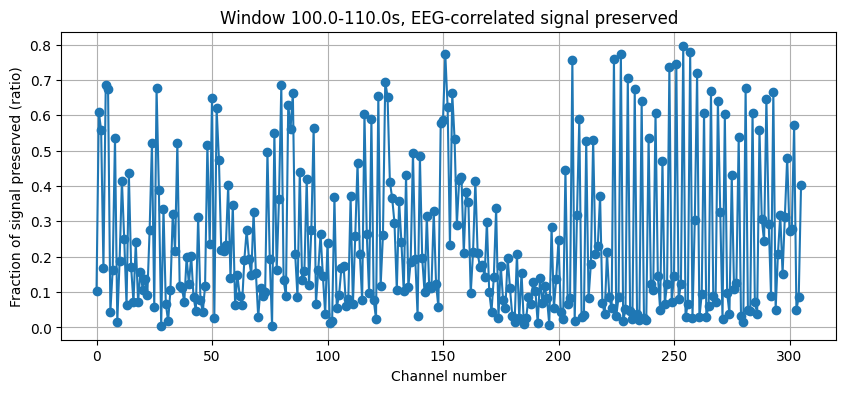

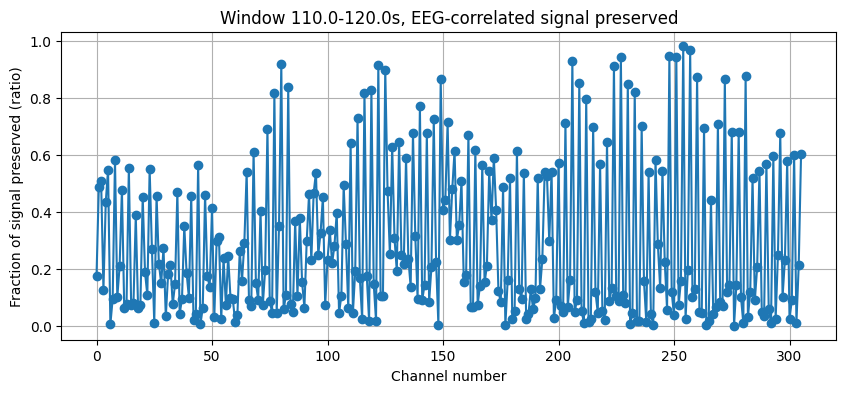

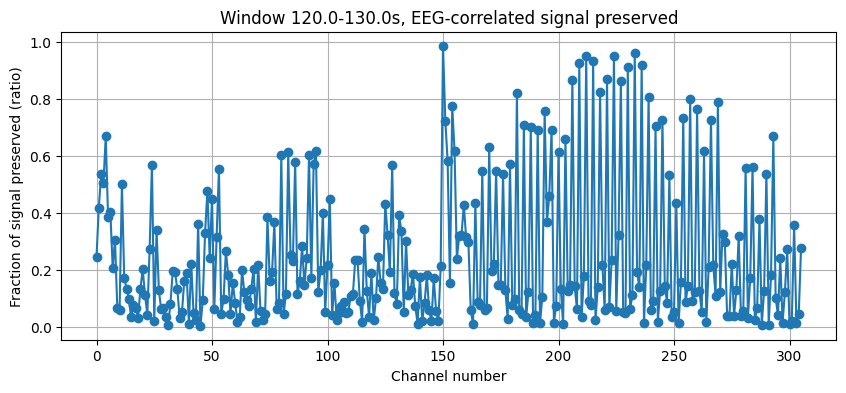

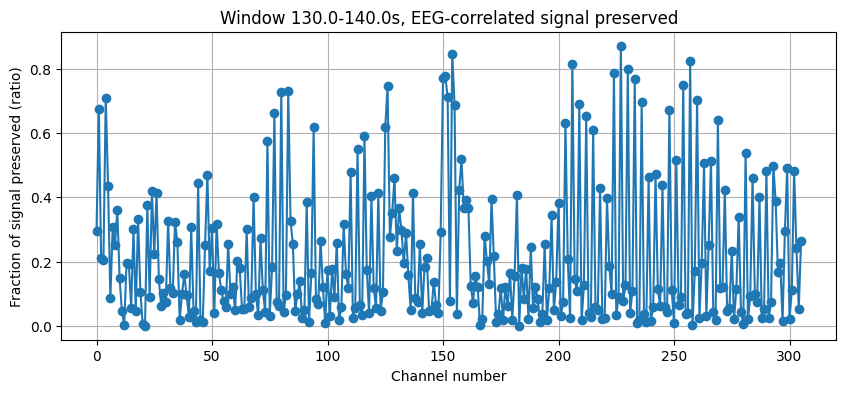

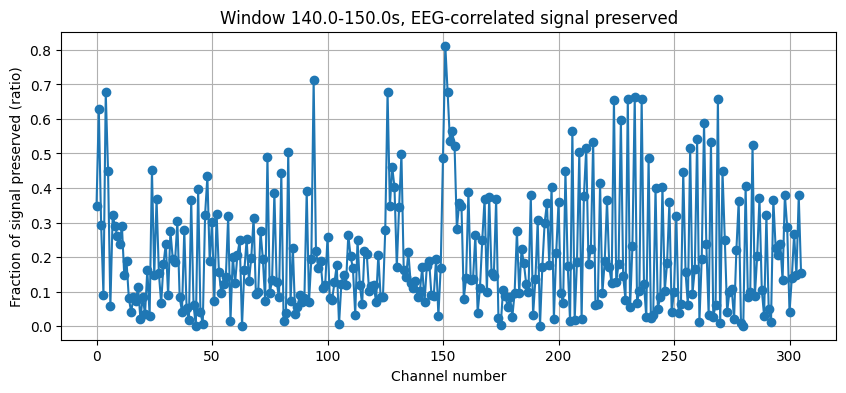

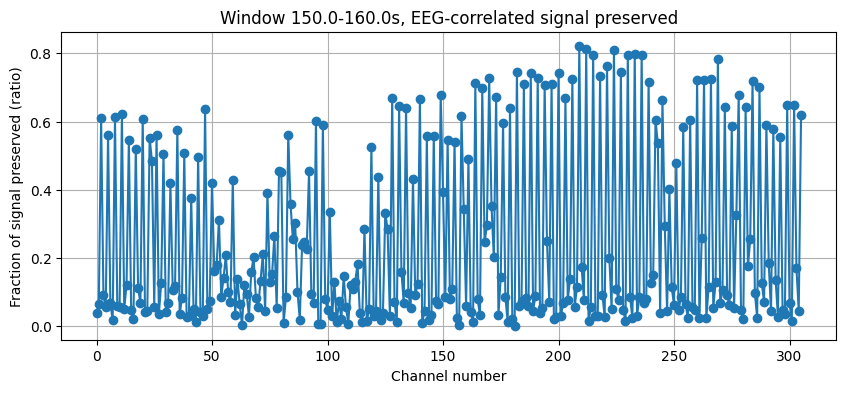

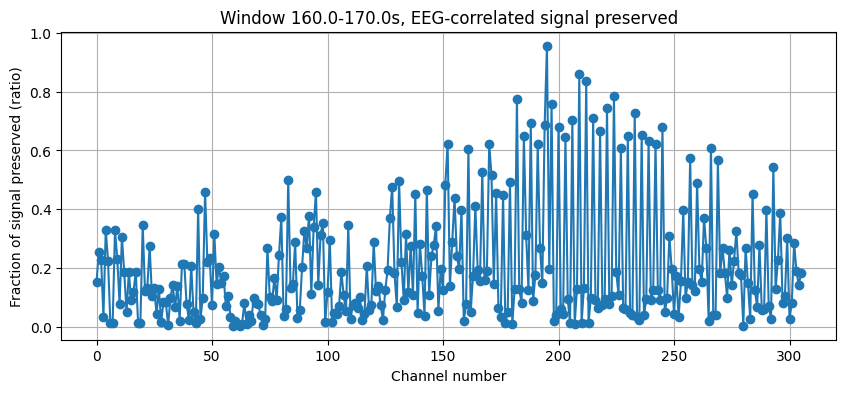

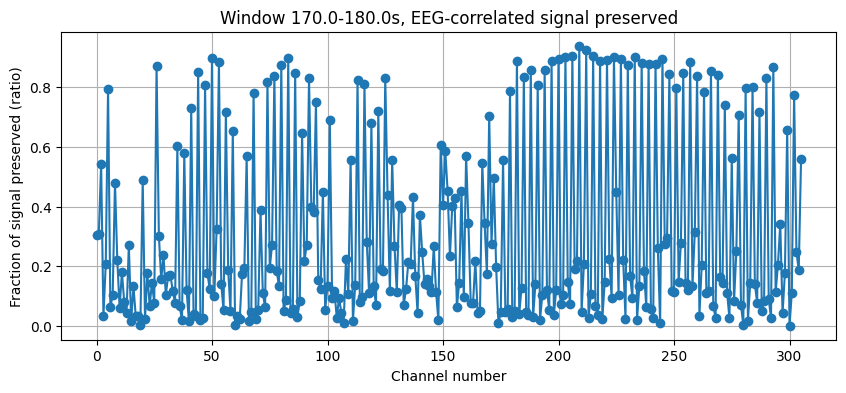

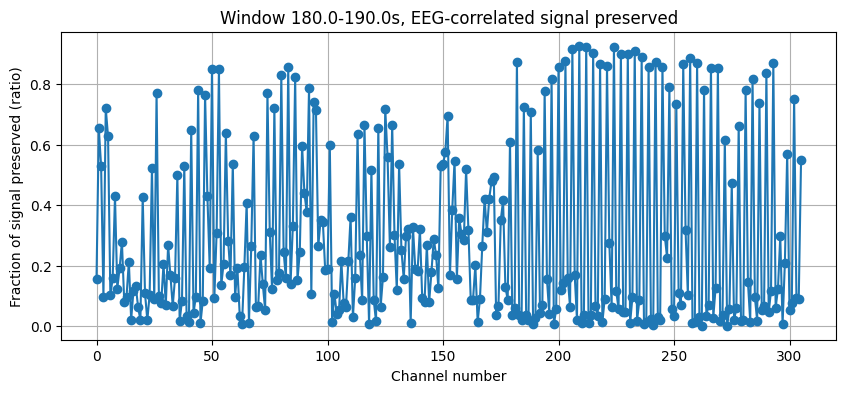

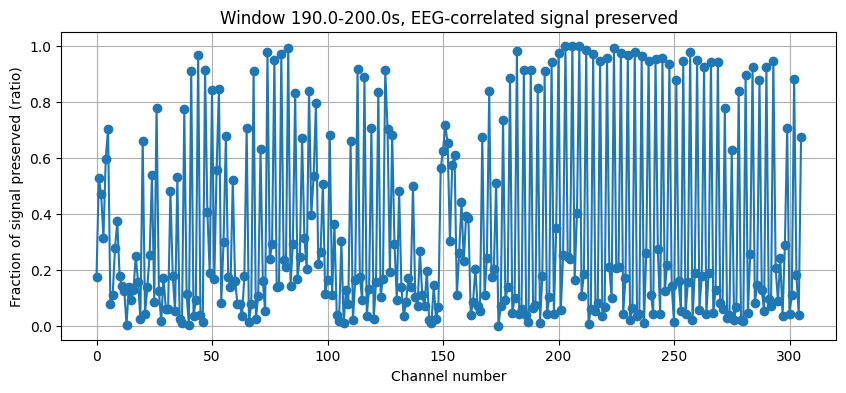

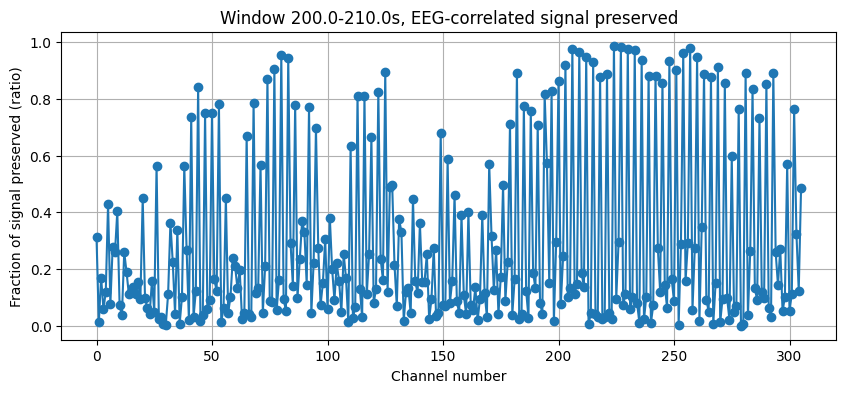

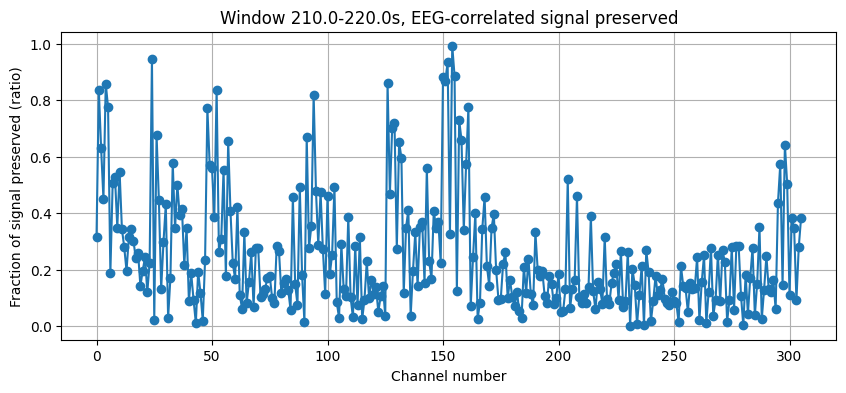

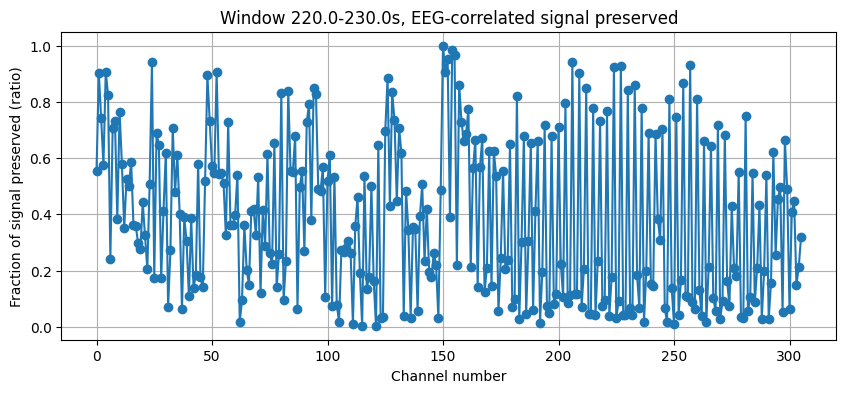

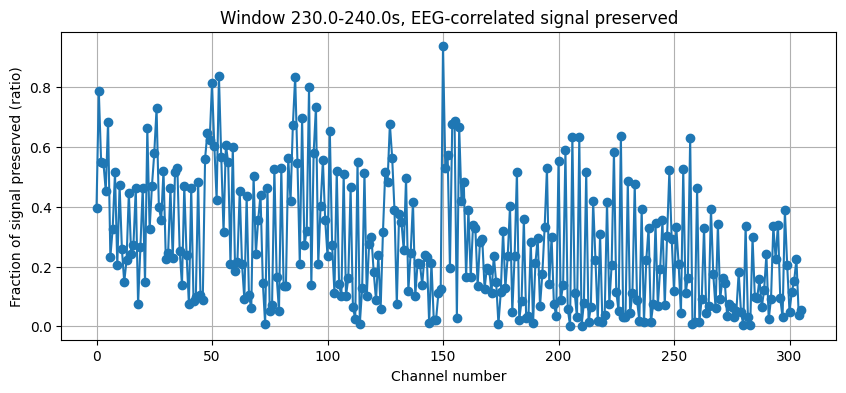

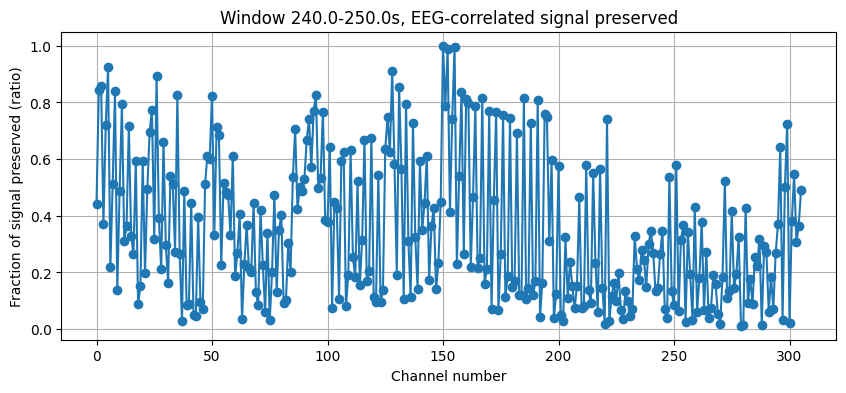

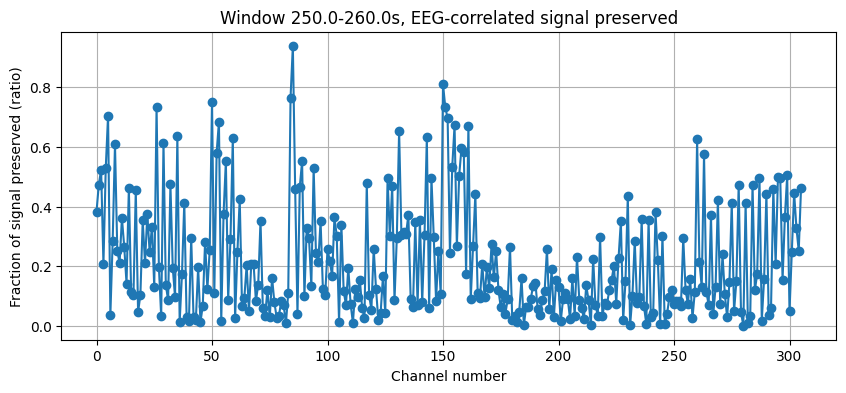

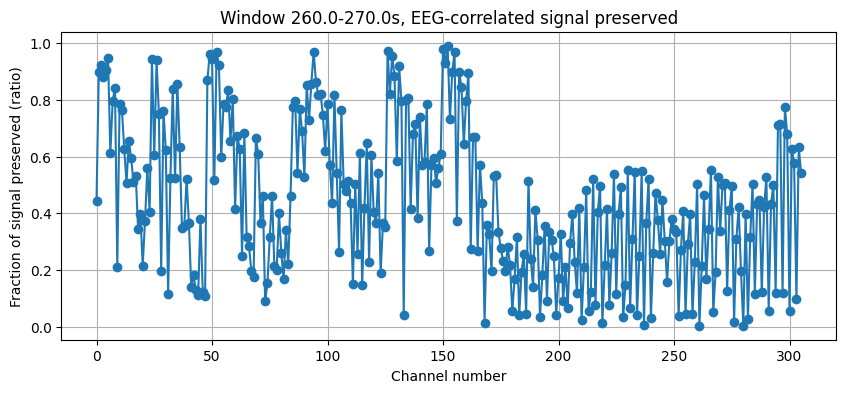

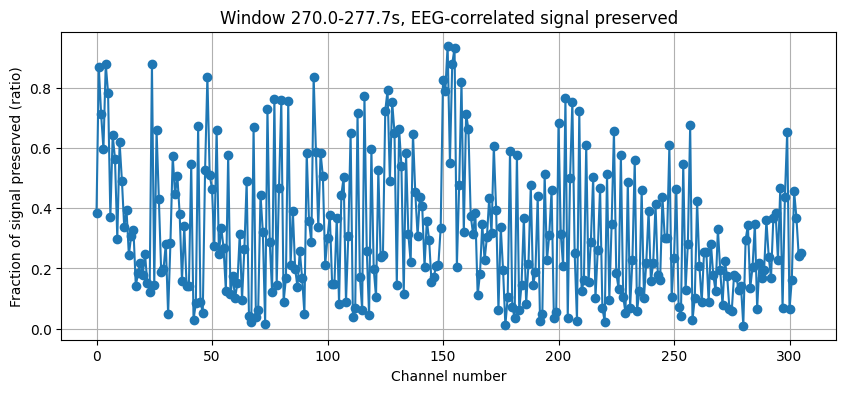

In [28]:
import mne
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
from mne.time_frequency import psd_array_welch


# Load sample data
data_folder = mne.datasets.sample.data_path()
data_raw_file = (data_folder / "MEG" / "sample" / "sample_audvis_raw.fif")
raw = mne.io.read_raw_fif(data_raw_file, preload=True)  # fif data

interval = 10  # steps for seconds
total_duration = raw.times[-1] #Total time
k = 3 # top components

#print(raw.info['ch_names'].index('MEG 0143'))
#raw.plot(picks=['MEG 0143'], block=True)


for start in np.arange(0, total_duration, interval):
    stop = min(start + interval, total_duration)

    # Separate EEG and MEG for this interval
    EEG_only = raw.copy().pick(picks='eeg').crop(tmin=start, tmax=stop)
    MEG_only = raw.copy().pick(picks='meg').crop(tmin=start, tmax=stop)

    eeg_data = EEG_only.get_data()
    meg_data = MEG_only.get_data()

    # Normalize, one to match N 
    eeg_norm = zscore(eeg_data, axis=1)
    meg_norm = zscore(meg_data, axis=1)

    #correlation matrix
    N = meg_norm.shape[1] #to divide by time points, better normilization 
    a = meg_norm @ eeg_norm.T / N #(meg, eeg)
    U, S, Vh = np.linalg.svd(a, full_matrices=True)

    # Projection stuff
    U_k = U[:, :k]
    P = U_k @ U_k.T
    meg_projected = P @ meg_norm

    times = MEG_only.times # For plots, can do eeg instead, will all be the same amount of time (277 seconds)
    
      # Top 5 correlated MEG channels for each window
    corr_strength = np.mean(np.abs(a), axis=1)
    top5_idx = np.argsort(corr_strength)[-3:]
    top5_names = [MEG_only.ch_names[i] for i in top5_idx]

    #Ratio of meg vs channel 
    preserved = np.sum(meg_projected**2, axis=1) / np.sum(meg_norm**2, axis=1)  #axis=1
    preserved_bound = np.minimum(preserved, 1.0)

    plt.figure(figsize=(10, 4))
    plt.plot(preserved_bound, marker='o')
    plt.xlabel('Channel number')
    plt.ylabel('Fraction of signal preserved (ratio)')
    plt.title(f'Window {start:.1f}-{stop:.1f}s, EEG-correlated signal preserved')
    plt.grid(True)
    plt.savefig(f'10_ratio_seconds/Preserved_{int(start)}_{int(stop)}.png')
    plt.show()  #shows which MEG sensors are mostly carrying activity that also shows up in EEG, and which MEG 
        #sensors are carrying more unique MEG-only information

# These are all the graphs, need to be moved up I think to forloop cell block to run correctly

In [ ]:
  # Top 5 correlated MEG channels for each window
    corr_strength = np.mean(np.abs(a), axis=1)
    top5_idx = np.argsort(corr_strength)[-3:]
    top5_names = [MEG_only.ch_names[i] for i in top5_idx]

    #eog_events = mne.preprocessing.find_eog_events(raw)
   # raw.plot(events=eog_events, order= EEG_only)
    #print(f"Window {start:.1f}-{stop:.1f} s, Top 5 MEG channels: {top5_names}")
    
    # Plot only those top 5 channels for this window
    #Normalized amp of MEG signal channels (y) vs time seconds(x)
    plt.figure(figsize=(12, 2.5*len(top5_idx)))
    for i, ch_idx in enumerate(top5_idx):
        plt.subplot(len(top5_idx), 1, i+1)
        plt.plot(times, meg_norm[ch_idx], alpha=0.6, label='Raw')
        plt.plot(times, meg_projected[ch_idx], alpha=0.8, label=f'Projected (k={k})')
        plt.ylabel(top5_names[i])
        if i == 0:
            plt.legend()
    plt.xlabel('Time (seconds)')
    plt.tight_layout()
    plt.savefig(f'10_seconds_time_plots/Seconds_Top5_{int(start)}_{int(stop)}.png')
    plt.show()

    #Ratio of meg vs channel 
    preserved = np.sum(meg_projected**2, axis=1) / np.sum(meg_norm**2, axis=1)  #axis=1
    plt.figure(figsize=(10, 4))
    plt.plot(preserved, marker='o')
    plt.xlabel('Channel number')
    plt.ylabel('Fraction of signal preserved (ratio)')
    plt.title(f'Window {start:.1f}-{stop:.1f}s, EEG-correlated signal preserved')
    plt.grid(True)
    plt.savefig(f'10_ratio_seconds/Preserved_{int(start)}_{int(stop)}.png')
    plt.show()

    #(SV)singular values to find top components, larger SVD=higher correlation 
    #Actual strength 
    n_plot = 30
    plt.figure()
    plt.plot(S[:n_plot], 'o-', markersize=5)
    plt.xlabel('Components')
    plt.ylabel('Singular value')
    plt.title(f'Window {start:.1f}-{stop:.1f}s, Singular values')
    plt.grid(True)
    plt.savefig(f'10_singular_values_Seconds/SingularValues_{int(start)}_{int(stop)}.png')
    plt.show()

    #Relative strength
    S_ratio = S / np.sum(S)  # fraction of variance, goes up to one, easier to read 
    print("Singular values > 1:", S[S > 1])
    plt.figure()
    plt.plot(S_ratio[:30], 'o-', markersize=5)
    plt.xlabel('Component')
    plt.ylabel('Fraction of shared variance')
    plt.title(f'Window {start:.1f}-{stop:.1f}s, Variance explained by components')
    plt.grid(True)
    plt.show()

    #PSD comparison (Frequency, power spectral density)
    channels_to_plot = np.linspace(0, meg_norm.shape[0]-1, n_plot, dtype=int)
    sfreq = raw.info['sfreq']
    plt.figure(figsize=(12, 2.5*n_plot))

    for i, ch_idx in enumerate(channels_to_plot):
        plt.subplot(n_plot, 1, i+1)
        f_raw, psd_raw = psd_array_welch(meg_norm[ch_idx], sfreq=sfreq, fmin=1, fmax=60, n_fft=2048)
        f_projected, psd_projected = psd_array_welch(meg_projected[ch_idx], sfreq=sfreq, fmin=1, fmax=60, n_fft=2048)
        plt.semilogy(f_raw, psd_raw, alpha=0.6, label='Raw')
        plt.semilogy(f_projected, psd_projected, alpha=0.8, label=f'projected k={k}')
        plt.ylabel(f'Chan {ch_idx}')
        if i==0:
            plt.legend()
    plt.xlabel('Frequency (Hz)')
    plt.tight_layout()
    plt.savefig("Frequency_vs_PSD")
    plt.show()